In [4]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [7]:
# Basics
import tensorflow as tf
import xarray as xr
import random

# Helpful
import tqdm

# Visualization
import matplotlib.pyplot as plt

# Path setup
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_local.EMOS_local_load_model import *  # Load EMOS_local_models
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.DRN.DRN_load_score_10 import *  # Load DRN_scores_10
from src.models.DRN.DRN_load_score_dummy_10 import *  # Load DRN_scores_10
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.u_net_load_score import *
from src.models.U_net.u_net_load_preds import *

<IPython.core.display.Javascript object>

### 1. Load scores

In [16]:
# Eq crps scores
eq_crps = xr.open_dataset("/mnt/sda/Data2/fourcastnet/data/results/eq_crps.h5")

# Baseline Scores
CRPS_baseline_scores_t2m = crps_load_lead_lat_lon("t2m")

# Global Scores:
EMOS_glob_scores_t2m = EMOS_global_load_score("t2m")

# Local Scores:
EMOS_loc_scores_t2m = EMOS_local_load_score("t2m")

# DRN 10 dummy scores:
DRN_scores_t2m_dummy_10 = DRN_load_score_dummy_10("t2m")

# U-net scores:
u_net_scores_t2m = u_net_load_score("t2m")

<IPython.core.display.Javascript object>

In [21]:
slice_large_lat = slice(50, 160)
slice_large_lon = slice(0, 110)

slice_small_lat = slice(0, 110)
slice_small_lon = slice(20, 130)

<IPython.core.display.Javascript object>

In [59]:
eq_scores_t2m = []
for lead in range(1, 32):
    eq_scores_t2m.append(
        eq_crps.eq.isel(
            phony_dim_3=slice_large_lat,
            phony_dim_4=slice_large_lon,
            phony_dim_2=2,
            phony_dim_1=lead,
        )
        .mean("phony_dim_0")
        .values
    )

<IPython.core.display.Javascript object>

In [79]:
eq_scores_t2m[0].mean()

0.3909124

<IPython.core.display.Javascript object>

In [135]:
def line_chart_all_scores(
    var_name, models=[True, True, True, True, True, True], land_sea=None
):
    """
    Plot a line chart with all of the mean scores over the lead_times.
    Args:
        var_name (str): Variable name to use for comparison
        models (list): Which models to add to the graph. 
    Returns:
        None
    """

    slice_large_lat = slice(50, 160)
    slice_large_lon = slice(0, 110)

    slice_small_lat = slice(0, 110)
    slice_small_lon = slice(20, 130)

    # Load all scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score_dummy_10,
        u_net_load_score,  # Added the U-net model's load function
    ]
    all_scores = []
    for count, boolean in enumerate(models[:-1]):  # Exclude the last model (EasyUQ)
        if boolean:
            all_scores.append(load_funcs[count](var_name))

    # Load EasyUQ scores
    if models[-1]:  # If EasyUQ model is selected
        eq_scores_t2m = []
        for lead in range(1, 32):
            eq_scores_t2m.append(
                eq_crps.eq.isel(
                    phony_dim_3=slice_large_lat,
                    phony_dim_4=slice_large_lon,
                    phony_dim_2=2,
                    phony_dim_1=lead,
                )
                .mean("phony_dim_0")
                .values
            )
        all_scores.append(eq_scores_t2m)
    # Continue your code as before...
    all_scores_mean = []
    if land_sea != None:
        land_sea_mask_dummy = np.load(
            "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
        )
        land_sea_mask_dummy = land_sea_mask_dummy[slice_small_lat, slice_small_lon]
        if land_sea == 0:
            land_sea_mask_dummy = np.logical_not(land_sea_mask_dummy)

        for model in range(len(all_scores) - 1):
            all_scores_mean.append([])
            for lead_time in range(31):
                slice_lead_time = all_scores[model][lead_time][
                    slice_small_lat, slice_small_lon
                ]
                all_scores_mean[model].append(
                    slice_lead_time[land_sea_mask_dummy == 1].mean()
                )
        all_scores_mean.append([])
        for lead_time in range(31):
            all_scores_mean[-1].append(
                all_scores[-1][lead_time][land_sea_mask_dummy == 1].mean()
            )
    else:
        # Making mean scores:
        all_scores_mean = []
        for model in range(len(all_scores)):
            all_scores_mean.append([])
            for lead_time in range(31):
                all_scores_mean[model].append(
                    all_scores[model][lead_time][
                        slice_small_lat, slice_small_lon
                    ].mean()
                )

    # Deciding on which scores to use:
    model_scores = all_scores_mean
    N = 31

    # Plotting line charts
    ind = np.arange(1, N + 1) * 6  # the x locations for the groups

    fig, ax = plt.subplots(figsize=(10, 6))

    labels_all = [
        "Raw Ensemble",
        "EMOS_global",
        "EMOS_local",
        "DRN",
        "U-net",
        "EasyUQ",
    ]  # Added "EasyUQ" to the labels
    colors_all = [
        "yellow",
        "green",
        "blue",
        "red",
        "black",
        "violet",
    ]  # Added "violet" to the colors

    labels_models = []
    colors_models = []
    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])
            colors_models.append(colors_all[count])

    # Iterate through lead times
    for model_index in range(len(labels_models)):
        ax.plot(
            ind,
            model_scores[model_index],
            color=colors_models[model_index],
            label=labels_models[model_index],
        )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Lead Times in Hours")
    ax.set_ylabel("Crps Scores")
    ax.set_title("Scores by lead time: " + var_name)
    ax.set_xticks(ind)
    ax.set_xticklabels([str(i) for i in ind])
    plt.xticks(rotation=60)
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>

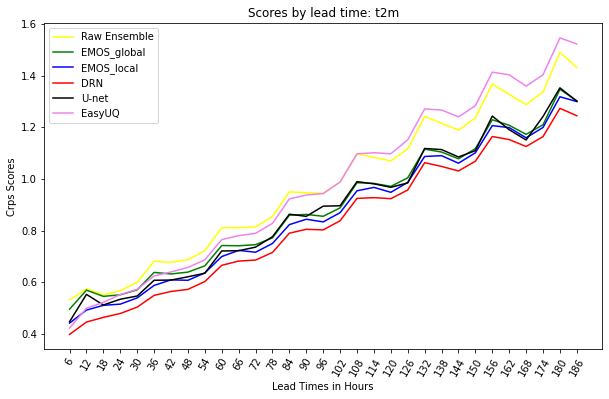

<IPython.core.display.Javascript object>

In [138]:
line_chart_all_scores("t2m", land_sea=None)

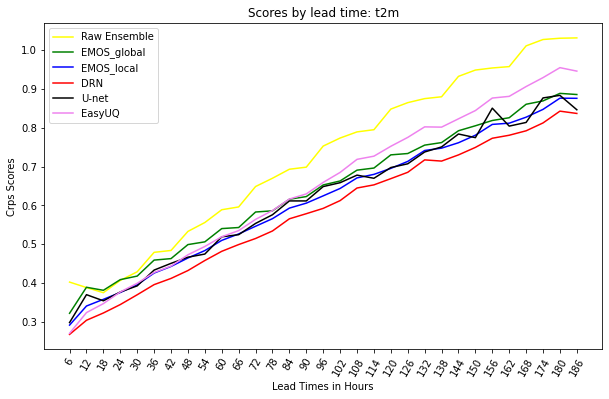

<IPython.core.display.Javascript object>

In [139]:
line_chart_all_scores("t2m", land_sea=0)

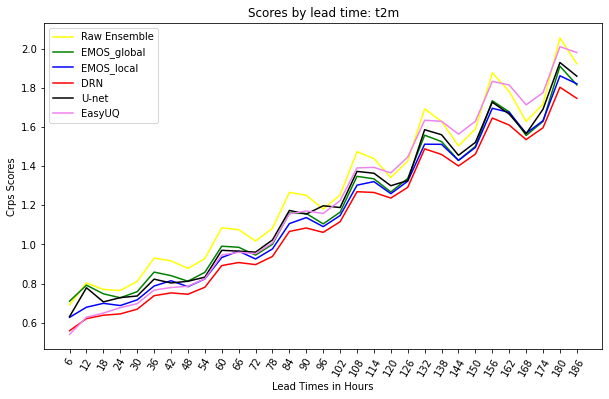

<IPython.core.display.Javascript object>

In [140]:
line_chart_all_scores("t2m", land_sea=1)